# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune


___

In [1]:
# connect to google drive -- after data are already generated
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("TensorFlow version: ", tf.__version__)
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = '/content/drive/My Drive/MothMachineLearning'
dataDir = os.path.join(baseDir, "Data", "PythonGeneratedData_oneTorque")
figDir = os.path.join(baseDir, "Figs")
dataOutput = os.path.join(baseDir, "DataOutput")
savedModels = os.path.join(baseDir, "SavedModels")
if not os.path.exists(figDir):
    os.mkdir(figDir)
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0
TensorFlow version:  2.1.0
The installed version of TensorFlow includes GPU support.
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] 

last run on 2020-01-30 23:52:02.154150


In [0]:
# Keras modules
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Keras callcacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

# Make training and test set

In [4]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [0]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)

# you can limit the size of the data like this:
# trainDF = pd.read_sql_query("SELECT * FROM train LIMIT 100000", con1)
# testDF = pd.read_sql_query("SELECT * FROM test LIMIT 100000", con1)
con1.close()

In [6]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [7]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [0]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [0]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [0]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [11]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [12]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [0]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [0]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [15]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


# Keras models

In [0]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [0]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

earlystop = EarlyStopping(monitor='val_mse', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [0]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

In [0]:
# train and trim weights

In [20]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_30__11_53_48
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               4400      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainabl

In [0]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [0]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [23]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    callbacks = [earlystop],
                    verbose = 2, batch_size=2**12, epochs = 100)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/100
8000000/8000000 - 12s - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/100
8000000/8000000 - 11s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 3/100
8000000/8000000 - 11s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/100
8000000/8000000 - 11s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/100
8000000/8000000 - 11s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/100
8000000/8000000 - 11s - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/100
8000000/8000000 - 11s - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/100
8000000/8000000 - 11s - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 9/100
8000000/8000000 - 11s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 10/100
8000000/8000000 - 11s - loss: 0.0

In [0]:
# save history
historyDict["mean_squared_error"].extend(history.history["mse"])
historyDict["val_mean_squared_error"].extend(history.history["val_mse"])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


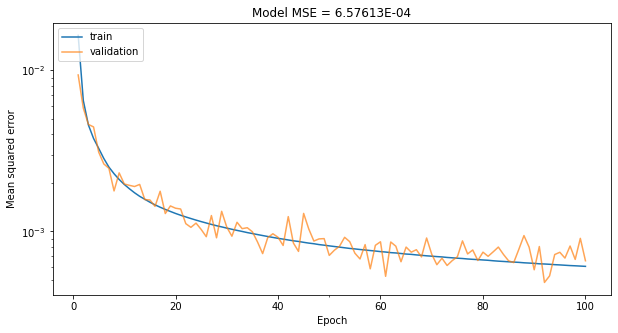

In [25]:
plot_model_history_fromDict(historyDict)

In [0]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

In [0]:
#  plot error rates on test data

In [28]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-8552.396484,15000.157227,-60794.246094,-561.583313,-1362.176147,-84.615227,-94.132957
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-312.740173,6785.784668,-67627.289062,55.063747,1389.040161,19.852728,2.599515
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-8028.735840,-13612.752930,-61481.417969,-1021.008362,-1401.814209,122.333595,113.323082
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,22321.740234,-5548.202637,51960.871094,-129.715256,-535.167908,99.295464,101.061417
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,-1022.059875,3125.369141,21677.099609,677.643982,-121.048424,-30.855192,-25.885130


In [0]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [0]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


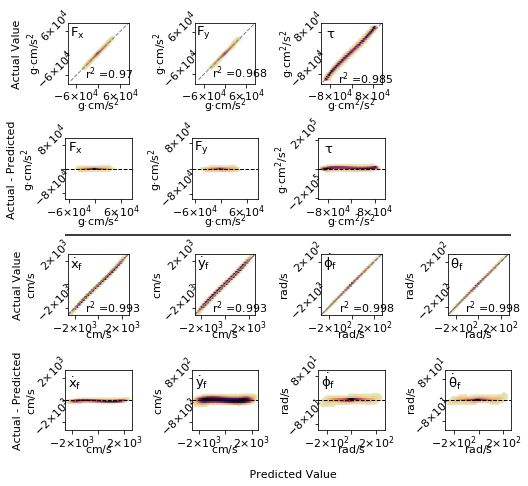

In [31]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

# Pruning
___

In [32]:
## Pruning
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_30__11_53_48'

In [0]:
# load model
from tensorflow.keras.models import load_model

K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_30__11_06_19"
modeltimestamp = "2020_01_30__11_06_19"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


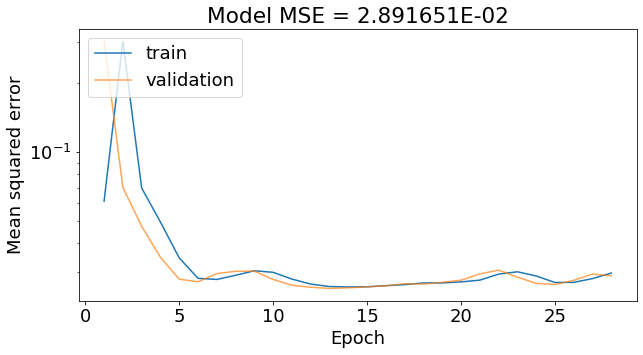

In [34]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

In [0]:
# train with pruning


In [0]:
# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [36]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent*2)

[ 0.         15.86485043 30.95069212 44.62436102 56.48995528 66.40367703
 74.42768674 80.75689166 85.64849155 89.36977272 92.16685544 94.25030081
 95.7917306  96.92645889 97.75871874 98.36748577 98.81189556 99.1358533
 99.37175734 99.54340943 99.66823978 99.75898315 99.82492807 99.87284121
 99.90764768 99.93292997]


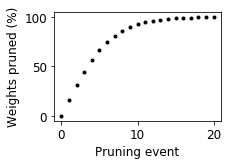

In [37]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

In [38]:
overallEpochCounter = len(historyDict['mean_squared_error'])
pruningStart = overallEpochCounter  # I start pruning immediately
cutPoints = [pruningStart]

numCuts = 0


# get weight sizes
wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

while True: 
    print(overallEpochCounter)  
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mse"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mse"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mse"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                  q = (50 - cutPercent[numCuts], 
                                       50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mse"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # add a data point to keep track of the epoch at which the pruning happened.
                cutPoints.append(overallEpochCounter)

                # save model
                model.save(os.path.join(savedModels,  modelSubdir, modelName + str(overallEpochCounter) + '_Pruned.h5'))
                
                
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break

    if numCuts >= len(cutPercent):
        break

28
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 12s - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0089 - val_mse: 0.0089
331735 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0056 - val_mse: 0.0056
331735 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0053 - val_mse: 0.0053
331735 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0036 - val_mse: 0.0036
331735 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0030 - val_mse: 0.0030
331735 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 0.0029 - mse: 0.0029 - val_loss: 

OSError: ignored

In [0]:
# plot training with vertical lines at places where I pruned
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)

# the last cut point is the end of the training, so leave it out
# also, don't do the first, one, because that is 0% cut
for vline in cutPoints[1:-1]:
    # add 1 to vlines to make them line up with jumps in error
    plt.vlines(vline+1, ymin = 0, ymax = np.max(historyDict["mean_squared_error"]), alpha = 0.5, linewidth = 0.9)

#plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [1, 5, 10, 18, 19, len(cutPercent)-1]: #range(1, len(cutPercent)):
    s = str(np.round(cutPercent[jj]*2, 2)) + "%"
    plt.plot(cutPoints[jj]+1, np.max(historyDict["mean_squared_error"]), "v", color = "black")
    plt.text(cutPoints[jj]+1, np.max(historyDict["mean_squared_error"]), s,
             {'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
# Hide the right and top spines
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [0]:
## Reload model with 80% of connections pruned and evaluate error

In [0]:
list(zip(cutPercent*2, cutPoints))

In [0]:
modelName

In [0]:
K.clear_session()
modelName = 'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_30__11_06_19'
epochNum = 208 # from above -- note that it will be off by 1 since I saved right after pruning
modelName2 =  modelName + str(epochNum) + "_Pruned"
modeltimestamp = "2020_01_30__11_06_19"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName2 + ".h5"))

In [0]:
wts = model.get_weights()
# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

In [0]:
1 - nzwts / np.sum(wtLengths)

In [0]:
numCuts = 7

cutPercent[numCuts]*2

In [0]:
for ii in range(10):
    history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                        verbose = 2, batch_size=2**12, epochs = 1)

    # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
    # get nonzero weights
    wts = model.get_weights().copy()

    # set weights close to 0 to 0 (but ignore biases)
    for ii in np.arange(0, len(wts), 1):
        qants = np.percentile(np.reshape(wts[ii], -1), 
                              q = (50 - cutPercent[numCuts], 
                                   50 + cutPercent[numCuts]), )
        wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

    # print nonzero weights
    # calculate number of nonzero weights
    nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
    print(nzwts, "of", np.sum(wtLengths), "weights retained")

    # set new weights and calculate new loss
    model.set_weights(wts)

In [0]:
model.evaluate(Xval_scaled, Yval_scaled)

In [0]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

In [0]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

In [0]:
# make plots
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()

In [0]:
np.max(df_c.loc[:,"Fy"] - df_c.loc[:,"Fy_pred"])

In [0]:
np.max( df_c.loc[:,"Fy_pred"])

In [0]:
np.max( df_c.loc[:,"Fy"])